In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import dictys
from dictys.net import stat
import joblib
import pickle
from scipy.stats import median_abs_deviation, hypergeom
import math

In [2]:
from utils_custom import *

In [3]:
# Define file paths
output_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files'
data_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output'

In [4]:
# Load data
dictys_dynamic_object = dictys.net.dynamic_network.from_file(os.path.join(data_folder, 'dynamic.h5'))

# Long trajectory (Day1 to terminal state)

## TF classification by activity (expression + degree dynamics)

In [42]:
lcurve_tf, dtime = compute_expression_regulation_curves(dictys_dynamic_object, start=1, stop=2, num=40, dist=0.001, mode="weighted_regulation")
#remove rows which have genes/TFs starting with 'ZNF' and 'ZBTB'
lcurve_tf = lcurve_tf[~lcurve_tf.index.str.startswith('ZNF') & ~lcurve_tf.index.str.startswith('ZBTB')]

In [37]:
display(lcurve_tf.head())
display(lcurve_tf.shape)

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
AHR,6.558803,6.584678,6.612542,6.642179,6.673285,6.705473,6.738268,6.771121,6.803418,6.834504,...,6.185460,6.092240,6.004882,5.924714,5.852263,5.787424,5.729673,5.678264,5.632378,5.591225
ARID3A,5.867621,5.922031,5.977335,6.033015,6.088485,6.143119,6.196266,6.247282,6.295568,6.340599,...,7.311496,7.388138,7.455740,7.513273,7.560709,7.598750,7.628525,7.651328,7.668437,7.681003
ARID3B,5.509839,5.552549,5.597616,5.644800,5.693791,5.744211,5.795617,5.847524,5.899417,5.950783,...,7.000746,7.056307,7.104578,7.145097,7.178057,7.204115,7.224182,7.239243,7.250245,7.258030
ARID5A,5.554049,5.612433,5.672221,5.732997,5.794283,5.855541,5.916183,5.975585,6.033103,6.088087,...,5.677155,5.581216,5.491566,5.409865,5.336822,5.272376,5.215951,5.166684,5.123619,5.085816
ARID5B,8.392434,8.448335,8.506443,8.566586,8.628542,8.692036,8.756736,8.822259,8.888165,8.953965,...,9.138047,9.074633,9.016324,8.964531,8.919801,8.882001,8.850554,8.824654,8.803427,8.786039


(328, 40)

#### Get curve chars

In [38]:
dchar_tf = compute_curve_characteristics(lcurve_tf, dtime)
display(dchar_tf.head())
display(dchar_tf.shape)

,Terminal logFC,Transient logFC,Switching time
AHR,-0.967578,0.166705,0.810157
ARID3A,1.813382,0.000000,0.505175
ARID3B,1.748191,0.000000,0.468621
ARID5A,-0.468232,0.410525,0.885244
ARID5B,0.393604,0.327500,0.085623


(328, 3)

In [39]:
dclass_tf = classify_tf_activity(dchar_tf, 'Terminal logFC', 'Transient logFC')
display(dclass_tf.head())
display(dclass_tf.shape)

,Terminal logFC,Transient logFC,Switching time,tf_class,terminal_z,transient_z,terminal_rank,transient_rank
AHR,-0.967578,0.166705,0.810157,Reductive,-0.733977,0.440651,97,147
ARID3A,1.813382,0.000000,0.505175,Cumulative,1.623869,-0.489094,40,120
ARID3B,1.748191,0.000000,0.468621,Cumulative,1.568596,-0.489094,43,120
ARID5A,-0.468232,0.410525,0.885244,Bell wave,-0.310605,1.800481,196,24
ARID5B,0.393604,0.327500,0.085623,Bell wave,0.420106,1.337436,154,38


(328, 8)

In [40]:
top_k_df = get_top_k_tfs_by_class(dclass_tf, k=15)
display(top_k_df)

,Reductive,Cumulative,Bell wave,U-shaped
0,HNF1B,PRDM1,BHLHE40,TFAP4
1,BACH2,VDR,NFATC4,E2F6
2,REL,E2F2,ETV5,YBX1
3,THRB,SOX2,NR4A2,CENPB
4,IRF8,BHLHE41,NR4A1,E2F4
5,TFEC,TP73,THRA,MLX
6,BCL11A,XBP1,STAT4,NFYA
7,STAT5A,RUNX2,FOSB,RREB1
8,EGR3,MBNL2,TBX19,ESRRG
9,FOXP1,CREB3L2,EGR2,ATF6


#### Plotting line plots

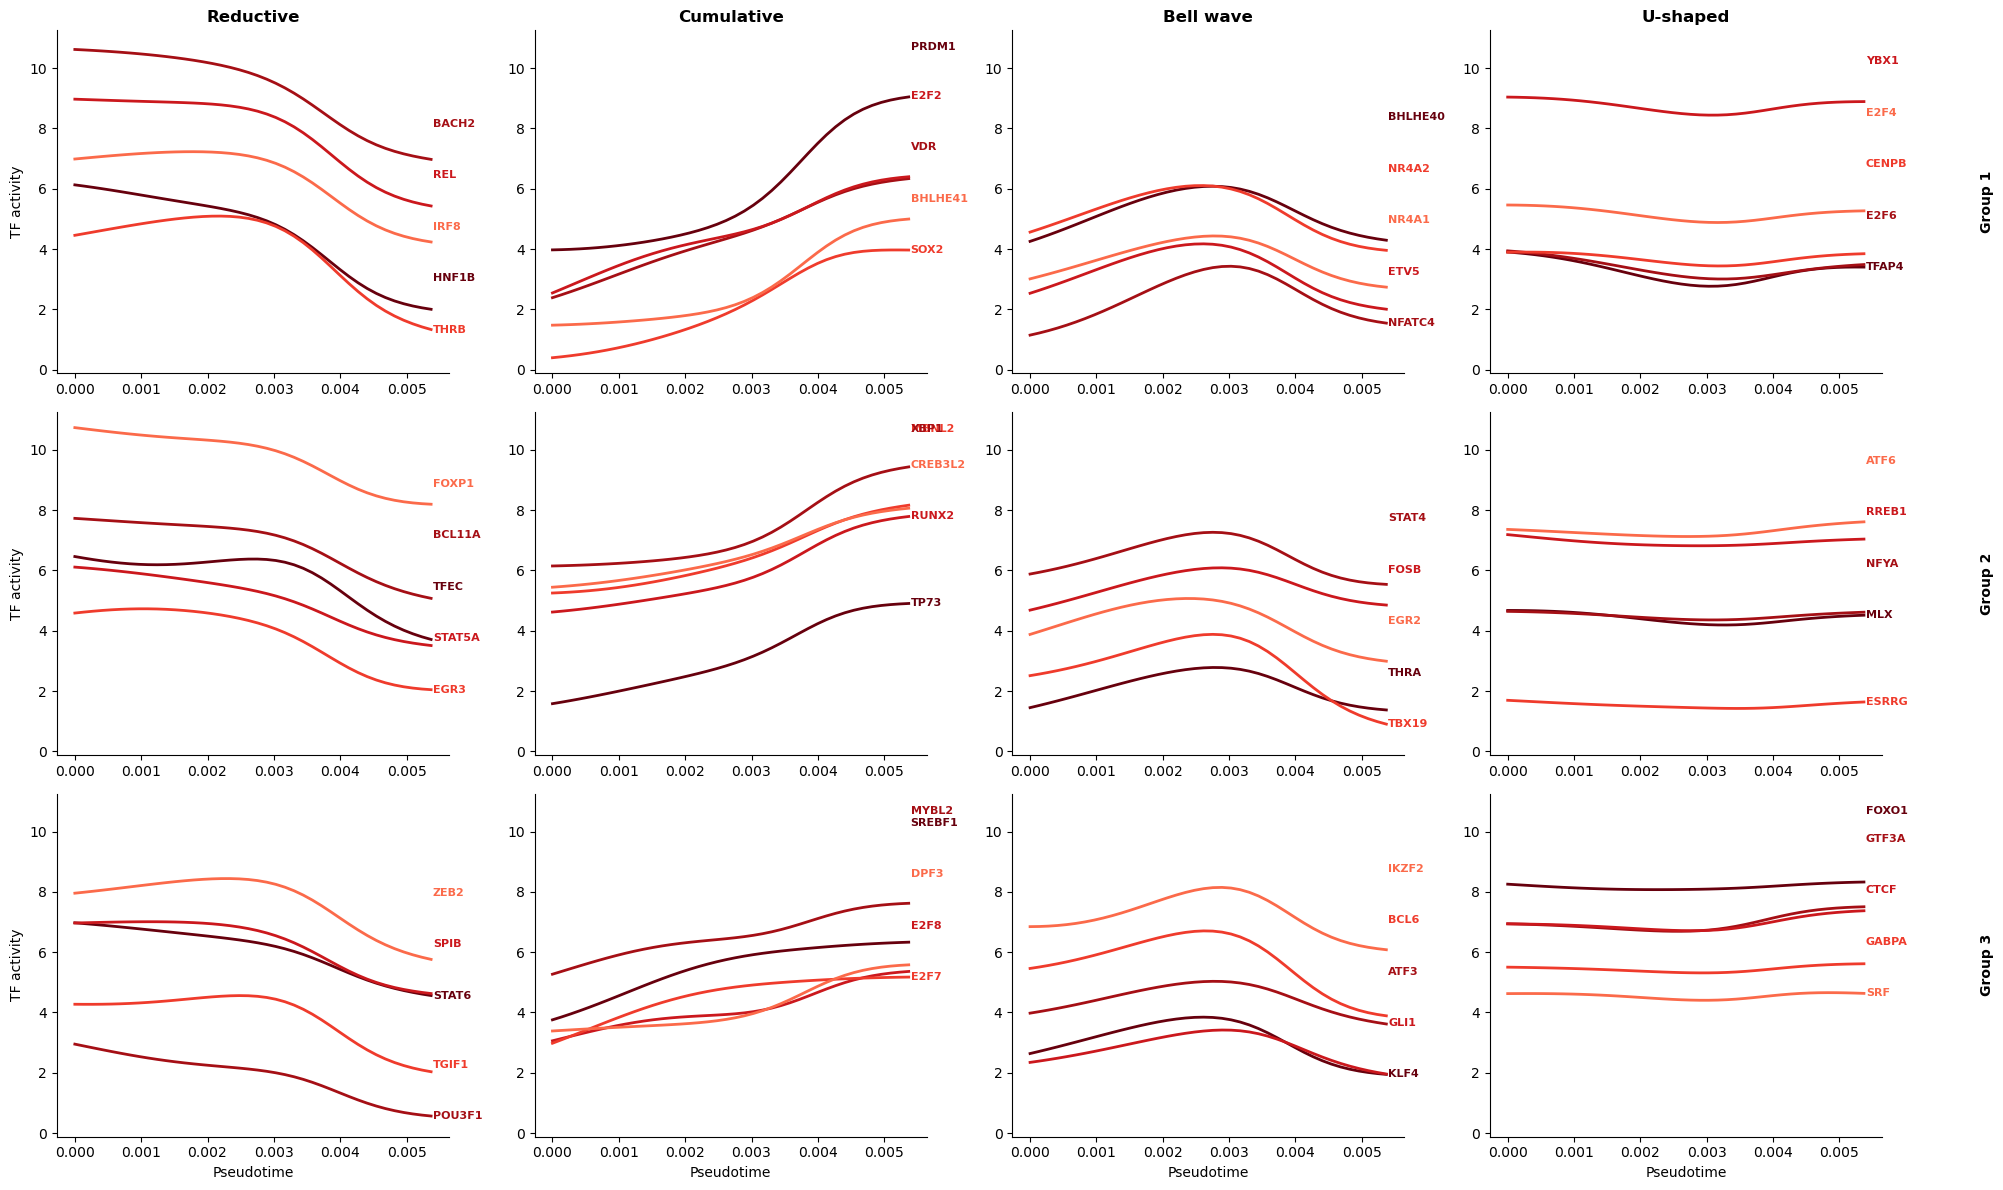

In [41]:
# Plot lcurve_tf for top TFs by class
import matplotlib.pyplot as plt
import numpy as np

# # Define colors for the 5 TFs per plot (shades of green)
# colors = ['#004d25', '#006837', '#238b45', '#41ab5d', '#74c476']
# Define colors for the 5 TFs per plot (shades of red)
colors = ['#67000d', '#a50f15', '#cb181d', '#ef3b2c', '#fb6a4a']

# Get all classes from top_k_df
classes = top_k_df.columns.tolist()

# Calculate global y-axis limits by finding min/max across all TFs to be plotted
all_tfs_to_plot = []
for class_name in classes:
    tf_list = top_k_df[class_name].tolist()
    for tf in tf_list:
        if tf in lcurve_tf.index:
            all_tfs_to_plot.append(tf)

# Get min and max values across all TFs
y_min = lcurve_tf.loc[all_tfs_to_plot].min().min()
y_max = lcurve_tf.loc[all_tfs_to_plot].max().max()

# Add small padding to the limits
y_padding = (y_max - y_min) * 0.05
y_min -= y_padding
y_max += y_padding

# Create subplot figure with 3 rows and 4 columns
fig, axes = plt.subplots(3, 4, figsize=(20, 12))

for col_idx, class_name in enumerate(classes):
    tf_list = top_k_df[class_name].tolist()
    
    # Split the 15 TFs into 3 groups of 5
    for row_idx in range(3):
        start_idx = row_idx * 5
        end_idx = start_idx + 5
        current_tfs = tf_list[start_idx:end_idx]
        
        ax = axes[row_idx, col_idx]
        
        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Store final y values for label positioning
        final_y_values = []
        tf_names = []
        colors_used = []
        
        # Plot each TF in the current group
        for i, tf in enumerate(current_tfs):
            if tf in lcurve_tf.index:
                ax.plot(dtime, lcurve_tf.loc[tf], linewidth=2, color=colors[i], label=tf)
                final_y_values.append(lcurve_tf.loc[tf].iloc[-1])
                tf_names.append(tf)
                colors_used.append(colors[i])
        
        # Position labels with better spacing to avoid overlap
        if final_y_values:
            y_range = y_max - y_min
            min_spacing = y_range * 0.15  # Increased minimum spacing to 15% of range
            
            # Sort by final y values
            label_data = list(zip(final_y_values, tf_names, colors_used))
            label_data.sort(key=lambda x: x[0])  # Sort by y value
            
            # Calculate optimal label positions
            label_positions = []
            for i, (original_y, tf_name, color) in enumerate(label_data):
                if i == 0:
                    # First label - use original position or minimum bound
                    label_y = max(y_min + y_range * 0.05, original_y)
                else:
                    # Subsequent labels - ensure minimum spacing from previous
                    prev_y = label_positions[-1]
                    label_y = max(original_y, prev_y + min_spacing)
                
                # Ensure we don't exceed upper bound
                label_y = min(label_y, y_max - y_range * 0.05)
                label_positions.append(label_y)
            
            # If labels exceed upper bound, redistribute them evenly
            if label_positions[-1] > y_max - y_range * 0.05:
                # Redistribute labels evenly across available space
                available_space = y_max - y_min - 2 * (y_range * 0.05)  # Leave margins
                if len(label_positions) > 1:
                    spacing = available_space / (len(label_positions) - 1)
                    for i in range(len(label_positions)):
                        label_positions[i] = y_min + y_range * 0.05 + i * spacing
                else:
                    label_positions[0] = y_min + available_space / 2
            
            # Place the labels
            for (original_y, tf_name, color), label_y in zip(label_data, label_positions):
                ax.text(dtime.iloc[-1] + (dtime.iloc[-1] - dtime.iloc[-2]) * 0.2, 
                       label_y, 
                       f'{tf_name}', 
                       color=color, 
                       verticalalignment='center',
                       fontsize=8,
                       fontweight='bold')
        
        # Set fixed y-axis limits for all plots
        ax.set_ylim(y_min, y_max)
        
        # Set labels
        if row_idx == 2:  # Bottom row
            ax.set_xlabel('Pseudotime')
        if col_idx == 0:  # Left column
            ax.set_ylabel('TF activity')
        
        # Set title for top row
        if row_idx == 0:
            ax.set_title(f'{class_name}', fontweight='bold')
        
        # Add group label on the right side
        if col_idx == len(classes) - 1:
            ax.text(1.25, 0.5, f'Group {row_idx + 1}', 
                   transform=ax.transAxes, 
                   rotation=90, 
                   verticalalignment='center',
                   fontweight='bold')

plt.tight_layout()
plt.show()
            
  